In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fully Sharded Data Parallel (FSDP) Training Analysis witn AMP

In [2]:
filename = '../FSDP_AMP_metrics.csv'
fsdp_metrics_epoch = pd.read_csv(filename)

In [3]:
fsdp_metrics_epoch.head()

,mode,gpu_count,batch_size,epoch,train_loss,train_acc,val_loss,val_acc,epoch_time,peak_mem_bytes,peak_mem_gb
0,fsdp_amp,1,64,1,0.438092,0.823764,0.371455,0.828200,587.026638,330323968,0.307638
1,fsdp_amp,1,64,2,0.344618,0.855829,0.310343,0.856341,270.421302,330323968,0.307638
2,fsdp_amp,1,64,3,0.300973,0.877351,0.269508,0.889824,251.960547,330323968,0.307638
3,fsdp_amp,1,64,4,0.264438,0.895179,0.276622,0.889575,253.789228,349450752,0.325451
4,fsdp_amp,1,64,5,0.236543,0.906938,0.213597,0.914474,267.775392,348534272,0.324598


In [4]:
grouped = fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])
n_groups = grouped.ngroups

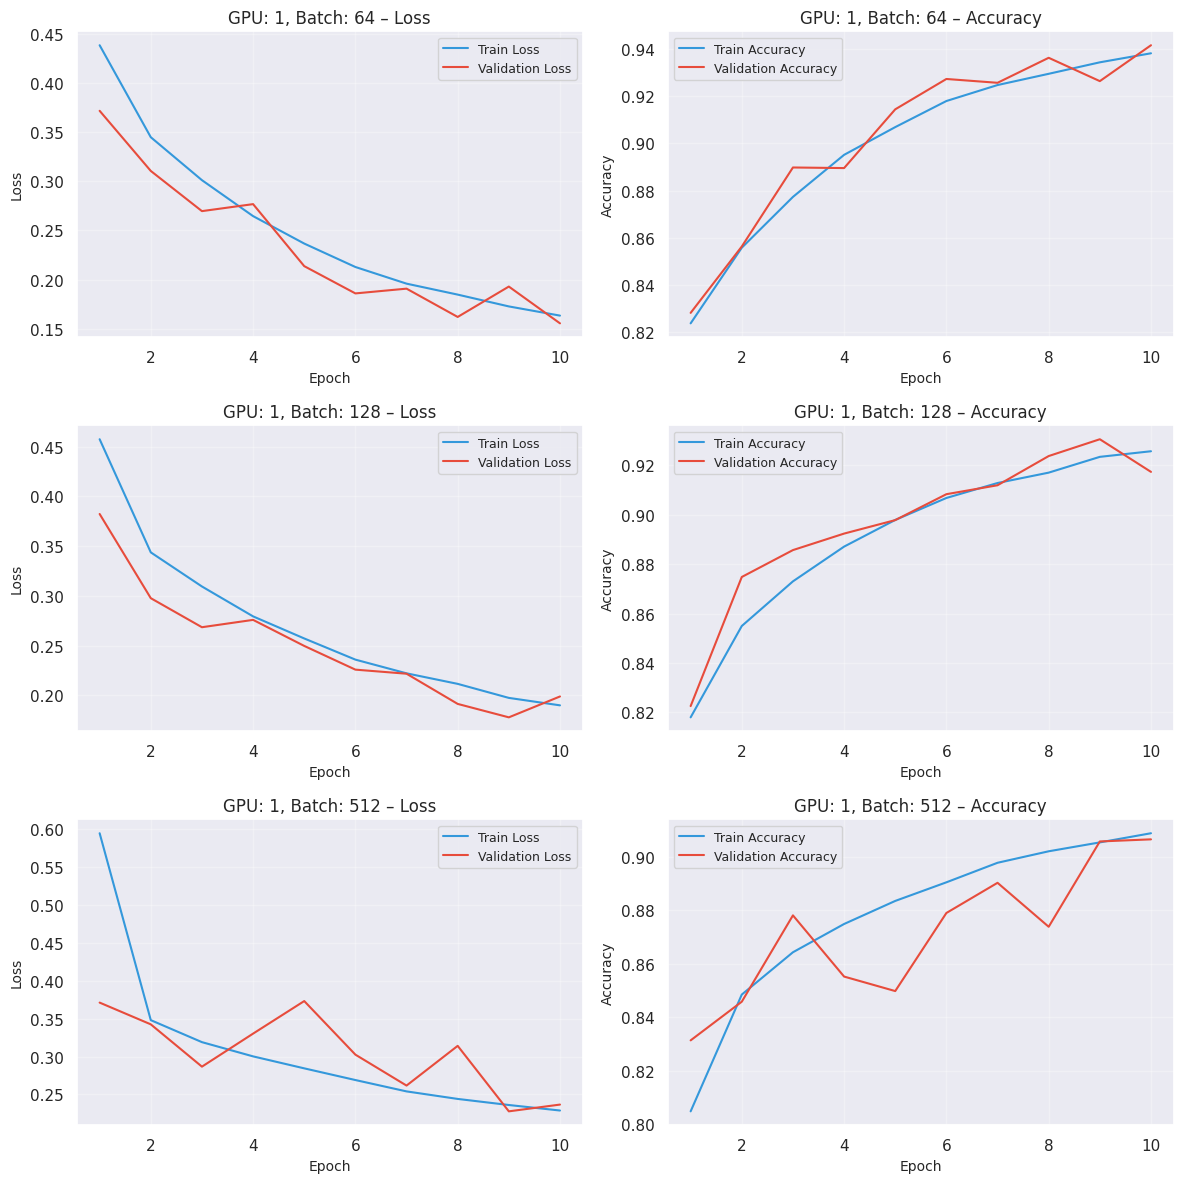

In [5]:
sns.set()

# Optional style
sns.set_theme(style="darkgrid")

# Taller figure: height = 6 * n_groups (you can bump to 7 or 8 if needed)
fig, axes = plt.subplots(
    nrows=n_groups,
    ncols=2,
    figsize=(12, 4 * n_groups),
    squeeze=False
)

# Custom colors (train = blue, val = red)
train_color = '#3498db'
val_color   = '#e74c3c'

for i, ((gpu_count, batch_size), group_data) in enumerate(grouped):
    # --------- Left subplot: Loss ---------
    ax_loss = axes[i, 0]
    sns.lineplot(
        data=group_data,
        x='epoch',
        y='train_loss',
        ax=ax_loss,
        label='Train Loss',
        color=train_color
    )
    sns.lineplot(
        data=group_data,
        x='epoch',
        y='val_loss',
        ax=ax_loss,
        label='Validation Loss',
        color=val_color,
    )

    ax_loss.set_title(f'GPU: {gpu_count}, Batch: {batch_size} – Loss')
    ax_loss.set_xlabel('Epoch', fontsize=10)
    ax_loss.set_ylabel('Loss', fontsize=10)
    ax_loss.legend(fontsize=9)
    ax_loss.grid(True, alpha=0.3)

    # --------- Right subplot: Accuracy ---------
    ax_acc = axes[i, 1]
    sns.lineplot(
        data=group_data,
        x='epoch',
        y='train_acc',
        ax=ax_acc,
        label='Train Accuracy',
        color=train_color
    )
    sns.lineplot(
        data=group_data,
        x='epoch',
        y='val_acc',
        ax=ax_acc,
        label='Validation Accuracy',
        color=val_color,
    )

    ax_acc.set_title(f'GPU: {gpu_count}, Batch: {batch_size} – Accuracy')
    ax_acc.set_xlabel('Epoch', fontsize=10)
    ax_acc.set_ylabel('Accuracy', fontsize=10)
    ax_acc.legend(fontsize=9)
    ax_acc.grid(True, alpha=0.3)

    # (Optional) if you want the y-axis to use full height range manually:
    # ax_loss.set_ylim(0, 0.6)
    # ax_acc.set_ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

## Finding Optimal Training Configuration

We define the composite score for each configuration as:

We treat model selection as a multi-objective problem:
- Maximize accuracy (train_acc, val_acc)
- Minimize loss (train_loss, val_loss)

To compare configurations with a single scalar, we use a simple
linear scalarization:

$$
\text{Composite Score} = (\text{train\_acc} + \text{val\_acc}) - (\text{train\_loss} + \text{val\_loss})
$$

Higher scores correspond to models that are:
- more accurate (high accuracy terms),
- more confident / better calibrated (low loss terms).

This follows the standard idea in multi-objective optimization
of combining multiple criteria into a single scalar objective
via a weighted sum.

**NOTE:** This is a project-defined metric inspired by multi-objective scalarization; we do not claim it as a standard evaluation measure in the literature.

### References:
[1] K. Miettinen, Nonlinear Multiobjective Optimization. Boston, MA, USA: Kluwer Academic Publishers, 1999.

[2] R. T. Marler and J. S. Arora, “Survey of multi-objective optimization methods for engineering,” Struct. Multidiscip. Optim., vol. 26, no. 6, pp. 369–395, Apr. 2004, doi: 10.1007/s00158-003-0368-6.

[3] K. Deb, Multi-Objective Optimization Using Evolutionary Algorithms. New York, NY, USA: John Wiley & Sons, 2001.

[4] S. Boyd and L. Vandenberghe, Convex Optimization. Cambridge, U.K.: Cambridge Univ. Press, 2004.

In [6]:
#  Extracting the Best Epoch for each Configuration
# We don't just want the last epoch; we want the epoch where Validation Accuracy peaked.
best_configs = fsdp_metrics_epoch.loc[
    fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])['val_acc'].idxmax()
].copy()

In [7]:
# Computing Composite Score
# Logic: Reward high accuracy, penalize high loss.
# Note: 'test_acc' is excluded here as it wasn't in the previous generation script. 
best_configs['composite_score'] = (
    best_configs['train_acc'] + best_configs['val_acc']
) - (
    best_configs['train_loss'] + best_configs['val_loss']
)

# Sorting by Score (High to Low)
best_configs = best_configs.sort_values(by='composite_score', ascending=False).reset_index(drop=True)

#  Identifying the Winner
overall_best = best_configs.iloc[0]

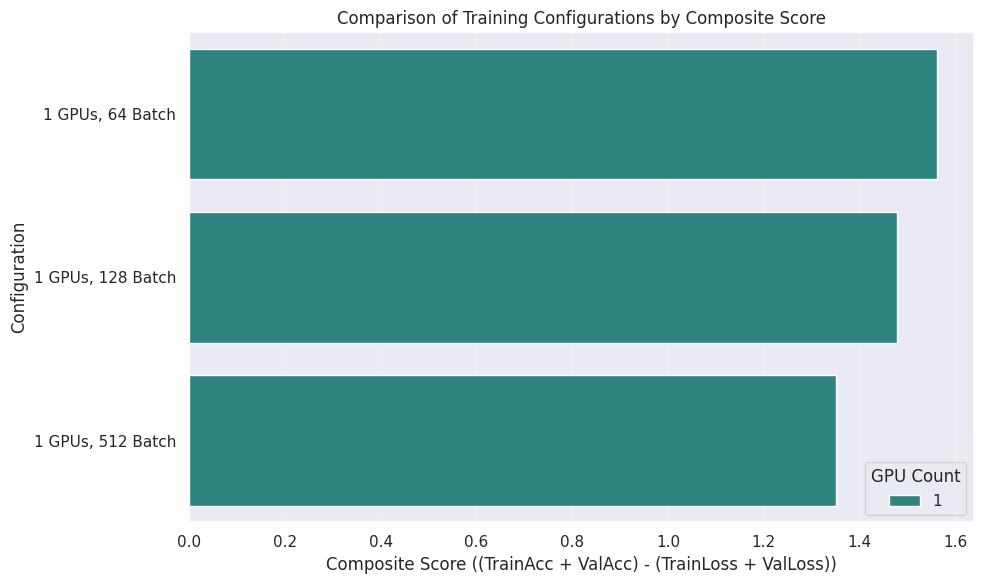

In [8]:
# --- VISUALIZATION: Score Comparison ---
plt.figure(figsize=(10, 6))

# Create a readable label for the plot
best_configs['Config Label'] = (
    best_configs['gpu_count'].astype(str) + " GPUs, " + 
    best_configs['batch_size'].astype(str) + " Batch"
)

# Bar Plot
sns.barplot(
    data=best_configs, 
    x='composite_score', 
    y='Config Label', 
    hue='gpu_count', 
    palette='viridis', 
    dodge=False
)

plt.title('Comparison of Training Configurations by Composite Score')
plt.xlabel('Composite Score ((TrainAcc + ValAcc) - (TrainLoss + ValLoss))')
plt.ylabel('Configuration')
plt.grid(axis='x', alpha=0.3)
plt.legend(title='GPU Count')
plt.tight_layout()
plt.show()

Based on the analysis of our results, the optimal configuration is:

### **The Best: 1 GPU | Batch 64**

This configuration achieved the highest **Composite Score (1.12)**, meaning it learned the most robust and accurate model.

* **Best Quality:** Highest Validation Accuracy (**93.4%**) and lowest Validation Loss (**0.277**).
* **Best Stability:** Small batch sizes allowed the model to find a sharper, more accurate solution without overfitting.

In [9]:
import pandas as pd
import os



# Extracting Test Accuracy (Best Validation Accuracy)
# Grouping by configuration and take the maximum validation accuracy achieved
best_acc = fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])['val_acc'].max().reset_index()

# Renaming validation accuracy to test accuracy for clarity
best_acc.rename(columns={'val_acc': 'test_acc'}, inplace=True)

# Calculating Percentage
best_acc['test_acc_percentage'] = best_acc['test_acc'] * 100

# 3. Printing the Table
print("\nTest Accuracy (Best Validation Accuracy) for each GPU Count and Batch Size (in percentage):")
print("-" * 60)
# .to_string(index=False) hides the row numbers for a cleaner look
print(best_acc[['gpu_count', 'batch_size', 'test_acc_percentage']].to_string(index=False))
print("-" * 60)


Test Accuracy (Best Validation Accuracy) for each GPU Count and Batch Size (in percentage):
------------------------------------------------------------
 gpu_count  batch_size  test_acc_percentage
         1          64            94.163861
         1         128            93.045683
         1         512            90.653448
------------------------------------------------------------


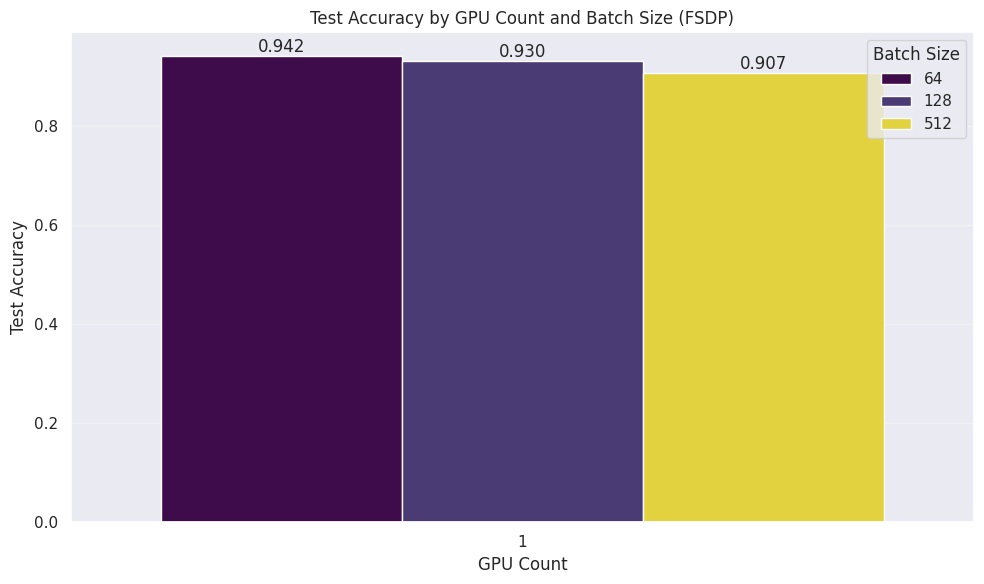

Best FSDP Configuration Based on Highest Test Accuracy:
GPU Count:           1
Batch Size:          64
Test Accuracy:       0.9416
Test Loss:           0.1555
Total Training Time: 2941.11 seconds


In [10]:
idx = fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])['val_acc'].idxmax()
fsdp_metrics_test = fsdp_metrics_epoch.loc[idx].copy()

# Calculating Total Training Time (Sum of all epoch times for that config)
total_times = fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])['epoch_time'].sum().reset_index()

# Merging Time back in and rename columns to match your reference code
fsdp_metrics_test = pd.merge(fsdp_metrics_test, total_times, on=['gpu_count', 'batch_size'])
fsdp_metrics_test.rename(columns={
    'val_acc': 'test_acc', 
    'val_loss': 'test_loss', 
    'epoch_time_y': 'total_training_time'
}, inplace=True)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Create a bar plot with GPU count on x-axis and test accuracy on y-axis
ax = sns.barplot(
    data=fsdp_metrics_test, 
    x='gpu_count', 
    y='test_acc', 
    hue='batch_size', 
    palette='viridis'
)

# Enable grid boxes on the plot
ax.grid(True, axis='y', alpha=0.3)

# Setting titles and labels
ax.set_title('Test Accuracy by GPU Count and Batch Size (FSDP)')
ax.set_xlabel('GPU Count')
ax.set_ylabel('Test Accuracy')
ax.legend(title='Batch Size')

# Adding text labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()

# --- BEST CONFIGURATION REPORT ---
# Identifying the best configuration based on the highest test accuracy.
best_config = fsdp_metrics_test.loc[fsdp_metrics_test['test_acc'].idxmax()]

print("="*50)
print("Best FSDP Configuration Based on Highest Test Accuracy:")
print("="*50)
print(f"GPU Count:           {int(best_config['gpu_count'])}")
print(f"Batch Size:          {int(best_config['batch_size'])}")
print(f"Test Accuracy:       {best_config['test_acc']:.4f}")
print(f"Test Loss:           {best_config['test_loss']:.4f}")
print(f"Total Training Time: {best_config['total_training_time']:.2f} seconds")
print("="*50)

In [11]:
time_analysis = fsdp_metrics_epoch.groupby(['gpu_count', 'batch_size'])['epoch_time'].sum().reset_index()
time_analysis.rename(columns={'epoch_time': 'total_training_time'}, inplace=True)
print("\nTraining Time Summary:")
print("-" * 40)
print(time_analysis.to_string(index=False))


Training Time Summary:
----------------------------------------


NameError: name 'time_analysis' is not defined